In [1]:
# default_exp geometry.rasterized_geometry

# Create rasterized geometry

The purpose of this module is to take an abstract geometry and realize it in format of a rasterized image

> API details.

In [2]:
#hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [3]:
#hide
import os, sys

sys.path.append(os.path.join(os.getcwd(), '..'))

In [4]:
#export
from shapely.geometry import Point, box, Polygon, MultiPoint, MultiPolygon, LineString, MultiLineString
from geocube.api.core import make_geocube
import geopandas as gpd
import numpy as np

from accelerate_simulations.geometry import AbstractGeometry

In [5]:
#hide
box_size = (100, 100)
circle_radius_range = (3, 7)
gap = 10
n_circles = 10

In [6]:
#hide
abstract_geometry = AbstractGeometry(n_circles, circle_radius_range, box_size, gap, 42)

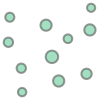

In [7]:
circles, box_corners = abstract_geometry.get_geom_info()
circles

In [8]:
#export
element_to_tag = {
    "circles": 1,
    "box_wo_circles": 2,
    "circles_boundaries": 3
}

In [23]:
#export
class GeometryRasterizer:
    def __init__(self, resolution):
        self.resolution = resolution

    def __call__(self, abstract_geometry: AbstractGeometry):
        circles, _ = abstract_geometry.get_geom_info()

        x_max, y_max = abstract_geometry.box_size
        grid_size = (x_max/self.resolution[0], y_max/self.resolution[1])

        boxx = self._make_box(circles, box_size=abstract_geometry.box_size)
        
        vector_data = self._make_geopandas_dataframe(circles, boxx)

        raster_array = make_geocube(
            vector_data=vector_data, 
            resolution=grid_size, 
            fill=0) 

        return raster_array

    def _make_geopandas_dataframe(self, circles, boxx):
        tags = list(element_to_tag.values())
        geometries = [circles, boxx, circles.boundary]

        g = gpd.GeoDataFrame(
            {"tags": tags},
            geometry=geometries,
            crs={"init": "epsg:4326"}
        )
        return g

    def _make_box(self, circles, box_size):
        boxx = box(0, 0, box_size[0], box_size[1])
        return boxx.difference(circles)

In [24]:
rasterize = GeometryRasterizer(resolution=(400, 400))
raster_array = rasterize(abstract_geometry)


In [25]:
x = np.array(raster_array.x)
y = np.array(raster_array.y)
raster_image = np.array(raster_array.tags)

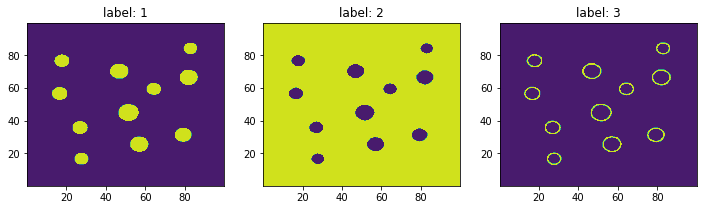

In [26]:
#hide
labels = [1, 2, 3]

fig, axs = plt.subplots(1, len(labels), figsize=(12, 3))
for idx, label in enumerate(labels):
    im = axs[idx].contourf(x, y, raster_image==label)
    axs[idx].set_title("label: " + str(label))

(1000, 1000)